# primeiro modelo: modelo 01

In [1]:
import pandas as pd

In [2]:
df_train = pd.read_pickle('Model_Train.pkl')
df_val = pd.read_pickle('Model_Val.pkl')

"""transforms = T.Compose([
    T.Resize((512,512)),
    T.ToTensor(),
])"""

"""def image_loader(image_name):
    image = Image.open(f"images/{image_name}.jpg").convert("RGB")
    image = transforms(image)
    #img = image.permute(1, 2, 0).numpy() # (C, H, W) -> (H, W, C)
    return image"""
''

''

---

## efficient net v2

# NOTAS

ANTES DE CORRER

- ~~ver se efficient net q escolhi é oq devo usar~~

- ~~faltou data augmentation~~

- ~~como escolher bem o batch~~

- ~~algum cv fold ou algo do tipo deve se usar ? NAO~~~

- ~~usar early stopping, patience 4, restore_best_weights=True~~

- ~~mais data augmentation~~

- ~~mudar tamanho da imagem em vez de 512 por 512~~

- inspirado em https://arxiv.org/pdf/2104.00298

- inspirado em https://zindi.africa/competitions/lacuna-solar-survey-challenge/discussions/25675

- ~~mudar max trials e isso do random search~~

In [3]:
image_paths = ("images/" + df_train["img_id"] + ".jpg").tolist()
labels = [(sum(row["nr_boil"]), sum(row["nr_pan"])) for i, row in df_train.iterrows()]


val_paths = ("images/" + df_val["img_id"] + ".jpg").tolist()
val_labels = [(sum(row["nr_boil"]), sum(row["nr_pan"])) for i, row in df_val.iterrows()]

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import AdamW
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.utils import Sequence

In [5]:
class ImageDataGeneratorCustom(tf.keras.utils.Sequence):
    def __init__(self, df, image_size=(240, 240), batch_size=32, shuffle=True, augment=False):
        self.df = df
        self.image_size = image_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.indexes = self.df.index.values
        self.on_epoch_end()

        if self.augment:
            self.transform = A.Compose([
                A.RandomResizedCrop((240, 240), scale=(0.7, 1.0), ratio=(0.75, 1.33)),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.GaussianBlur(blur_limit=(3, 7), p=0.3),
                A.CLAHE(clip_limit=4.0, p=0.5),
                A.HueSaturationValue(p=0.3),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2()
            ])
        else:
            # If no augmentation, only resize and normalize
            self.transform = A.Compose([
                A.Resize(self.image_size[0], self.image_size[1]),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2()
            ])

    def __len__(self):
        # Calculate the number of batches per epoch
        return int(np.floor(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        # Shuffle the data at the end of each epoch if shuffle is True
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)
            #np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        # Get batch of data
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df = self.df.iloc[batch_indexes]

        images = []
        labels = []

        for i, row in batch_df.iterrows():
            # Load image
            image_path = "images/" + row['img_id'] + '.jpg'
            img = load_img(image_path, target_size=self.image_size)
            img = img_to_array(img)  # Convert to numpy array
            img = img / 255.0 # Normalize pixel values
            
            img = self.transform(image=img)["image"]

            if img.shape[0] == 3:  # If it's in channels-first format (3, 512, 512)
                img = np.transpose(img, (1, 2, 0))

            
            images.append(img)
            labels.append((sum(row["nr_boil"]), sum(row["nr_pan"])))  # Assuming 'label' is the target

        return np.array(images), np.array(labels)


In [6]:
train_generator = ImageDataGeneratorCustom(df_train, image_size=(240, 240), batch_size=32, shuffle=True, augment=True)
val_generator = ImageDataGeneratorCustom(df_val, image_size=(240, 240), batch_size=32, shuffle=False, augment=False)

In [7]:
import keras_tuner as kt
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetV2B0, EfficientNetV2B1
from tensorflow.keras.losses import Huber
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def build_model(hp):
    model = Sequential()

    # Base model
    base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(240, 240, 3))
    base_model.trainable = False
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    
    model.add(layers.Dense(
        units=hp.Int('units', min_value=64, max_value=240, step=64),
        activation='relu'
    ))
    
    # Dropout layer for regularization
    model.add(layers.Dropout(0.5))
    
    # Output layer with no activation (regression)
    model.add(layers.Dense(2))

    model.compile(optimizer=AdamW(learning_rate=hp.Float('lr', min_value=1e-5, max_value=1e-2, sampling='log')), 
                  loss=Huber(delta=1.0), 
                  metrics=['mae'])
    
    return model


In [8]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',  # You can change this to 'val_mae' or other metrics as needed
    max_trials=5,  # The number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of times to train the model for each trial
    directory='ModelBuild',  # Directory where results are stored
    project_name='model01_v04'
)

Reloading Tuner from ModelBuild/model01_v04/tuner0.json


2025-03-18 21:16:31.584850: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-03-18 21:16:31.584877: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-18 21:16:31.584880: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-18 21:16:31.584895: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-18 21:16:31.584905: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
import tensorflow as tf
from tensorflow.keras import callbacks
from time import time

tuner.search(train_generator,
             epochs=15,
             validation_data=val_generator,
             callbacks=[callbacks.EarlyStopping(monitor='val_mae', patience=3, restore_best_weights=True),
                        callbacks.ModelCheckpoint(f'ModelBuild/model01_v04/{int(time())}.h5', monitor='val_accuracy', save_best_only=True)])

In [10]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)

{'units': 128, 'lr': 0.00013602929586136787}


{'units': 128, 'lr': 0.00013602929586136787}

---

visualization

In [11]:
def build_model():
    model = Sequential()

    # Base model
    base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(240, 240, 3))
    base_model.trainable = False
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    
    model.add(layers.Dense(
        units=128,
        activation='relu'
    ))
    
    # Dropout layer for regularization
    model.add(layers.Dropout(0.5))
    
    # Output layer with no activation (regression)
    model.add(layers.Dense(2))

    model.compile(optimizer=AdamW(learning_rate=0.00014), 
                  loss=Huber(delta=1.0), 
                  metrics=['mae'])
    
    return model

In [12]:
model = build_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 8, 8, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,083,538 (23.21 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [13]:
#history = model.fit(train_generator,
#          validation_data=val_generator,
#          epochs=15,
#          callbacks=[callbacks.EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)])

#model.save('ModelBuild/model01_v04.keras')

In [14]:
plt.rcParams.update({
    "text.usetex": True,              # If you want to use LaTeX fonts in text
    "font.family": "serif",           # IEEE uses Times New Roman-like fonts
    "font.size": 12,                   # General font size for IEEE format
    "axes.labelsize": 12,              # Axis labels font size
    "legend.fontsize": 11,             # Legend font size
    "xtick.labelsize": 11,             # X-axis tick labels font size
    "ytick.labelsize": 11,             # Y-axis tick labels font size
    "figure.figsize": (5, 5*0.65),
    "savefig.dpi": 300,               # DPI for high-quality PNG/JPEG
})

In [15]:
import json


# Specify the file name
file_name = "ModelBuild/model01_v04.json"

# Open the file and write the dictionary as JSON
#with open(file_name, "w") as json_file:
#    json.dump(history.history, json_file, indent=4)

print(f"Data has been written to {file_name}")

Data has been written to ModelBuild/model01_v04.json


In [16]:
with open(file_name, "r") as json_file:
    data = json.load(json_file)

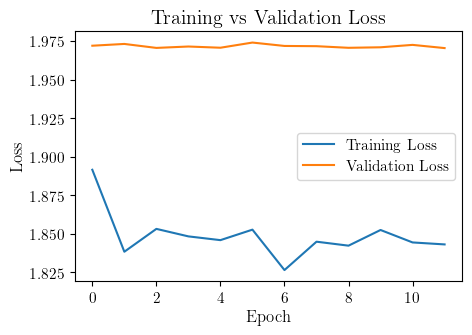

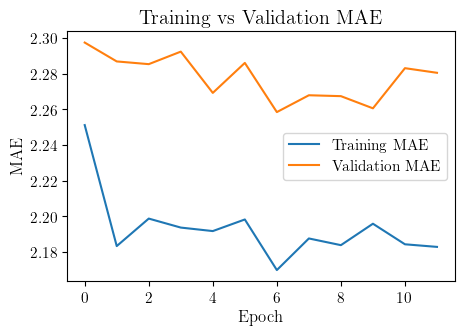

In [17]:
plt.plot(data['loss'], label='Training Loss')
plt.plot(data['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(data['mae'], label='Training MAE')
plt.plot(data['val_mae'], label='Validation MAE')
plt.title('Training vs Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

## prever dados de treino

In [18]:
df_test = pd.read_csv('Test.csv')
df_test.head()

,ID,img_origin,placement
0,ID00qprY,D,roof
1,ID01AciUc,D,roof
2,ID0328D,D,roof
3,ID05WxObCFTs9,D,roof
4,ID06AdCmLMlkO,S,S-unknown


In [19]:
image_size=(240, 240)

transform = A.Compose([
            A.Resize(image_size[0], image_size[1]),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

# prepare the images
images = []
for i, row in df_test.iterrows():
    # Load image
    image_path = "images/" + row['ID'] + '.jpg'
    img = load_img(image_path, target_size=image_size)
    img = img_to_array(img)
    img = img / 255.0
    img = transform(image=img)["image"]

    if img.shape[0] == 3:  # If it's in channels-first format (3, 512, 512)
        img = np.transpose(img, (1, 2, 0))

    images.append(img)

images = np.array(images)

In [20]:
# load the model

model = tf.keras.models.load_model('ModelBuild/model01_v04.keras')

In [21]:
x = model.predict(images)

2025-03-18 21:17:28.247953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 265ms/step


In [22]:
x

array([[0.08732566, 1.6987917 ],
       [0.08734137, 1.6986835 ],
       [0.08737129, 1.6986818 ],
       ...,
       [0.08736788, 1.6986834 ],
       [0.08734728, 1.6987073 ],
       [0.08735065, 1.6986723 ]], dtype=float32)

claramente ele n vais buscar as features que devia... mais parece uma media...

boil | pan

In [24]:
submission = pd.read_csv("zindi_files/SampleSubmission.csv")
submission.head()

,ID,Target
0,ID00qprY_boil,0
1,ID00qprY_pan,0
2,ID01AciUc_boil,0
3,ID01AciUc_pan,0
4,ID0328D_boil,0


In [27]:
df_test["nr_boil"] = x[:, 0]
df_test["nr_pan"] = x[:, 1]

for i, row in submission.iterrows():
    image = row["ID"].replace("_pan", "").replace("_boil", "")
    object = row["ID"].split("_")[-1]
    if object == "boil":
        submission.loc[i, "Target"] = df_test[df_test["ID"] == image]["nr_boil"].values[0]
    else:
        submission.loc[i, "Target"] = df_test[df_test["ID"] == image]["nr_pan"].values[0]
    
submission

/var/folders/sz/96b_h5gn3y33k0c7jsvrstmm0000gn/T/ipykernel_55946/2436842366.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.08732566237449646' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  submission.loc[i, "Target"] = df_test[df_test["ID"] == image]["nr_boil"].values[0]


,ID,Target
0,ID00qprY_boil,0.087326
1,ID00qprY_pan,1.698792
2,ID01AciUc_boil,0.087341
3,ID01AciUc_pan,1.698684
4,ID0328D_boil,0.087371
...,...,...
2209,IDzwPcyO0e_pan,1.698683
2210,IDzzNegz_boil,0.087347
2211,IDzzNegz_pan,1.698707
2212,IDzzZcEYNVZMCk_boil,0.087351


In [28]:
submission.to_csv("zindi_files/model01_v04.csv", index=False)

**public socre:** 3.040397919